<a href="https://colab.research.google.com/github/hero-hub/cnn_psf/blob/main/cnn_resnet_2layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import zipfile
import sys

2025-10-26 08:53:56.704298: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761468836.906263      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761468836.962777      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Параметры для расчёта диаметра

In [2]:
# Параметры для расчета диаметра
k = 4
Magn = 20
PixSize0 = 3.45

# Расчет диаметра пятна в пикселях
d_pix = 1.22 * 0.543 * 2 * k * Magn * 6.14 / PixSize0
print(f"Диаметр пятна: {d_pix:.2f} пикселей")

# Функция для преобразования ошибки из пикселей в доли диаметра
def pixels_to_diameter_fraction(error_pixels, diameter=d_pix):
    return error_pixels / diameter

# Максимальная абсолютная ошибка в пикселях
def max_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.reduce_max(tf.abs(y_true - y_pred))

# RMSE в долях диаметра
def rmse_diameter_fraction(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    rmse_pixels = tf.sqrt(mse)
    return rmse_pixels / d_pix

# Максимальная ошибка в долях диаметра
def max_error_diameter_fraction(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    max_err_pixels = tf.reduce_max(tf.abs(y_true - y_pred))
    return max_err_pixels / d_pix

Диаметр пятна: 188.64 пикселей


# Загрузка и подготовка данных


In [3]:
# Путь к папке, где находится library_help_tools.py
sys.path.insert(0, '/kaggle/input/toolss')

print(sys.path)

try:
    import library_help_tools as lht
    print("Модуль успешно импортирован!")
except ModuleNotFoundError as e:
    print(f"Ошибка импорта: {e}")

# Максимальная абсолютная ошибка
def max_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Приводим y_true к float32
    y_pred = tf.cast(y_pred, tf.float32)  # Приводим y_pred к float32
    return tf.reduce_max(tf.abs(y_true - y_pred))

['/kaggle/input/toolss', '/kaggle/working', '/kaggle/lib/kagglegym', '/kaggle/lib', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/usr/local/lib/python3.11/dist-packages/setuptools/_vendor', '/root/.ipython']
Модуль успешно импортирован!


In [4]:
zip_directory = '/kaggle/input/128-16090-20x/128_16090_20x/'
print(os.listdir())

def load_images_from_directory(dir_read):
    images = []  # Список для хранения изображений
    list_file = os.listdir(dir_read)  # Получаем список файлов в директории

    for cur_file in list_file:
        cur_file_path = os.path.join(dir_read, cur_file)
        try:
            img = Image.open(cur_file_path)
            images.append(img)
        except Exception as e:
            print(f"Ошибка при чтении файла {cur_file_path}: {e}")

    print(f'Количество загруженных изображений - {len(images)}')
    return images

images = load_images_from_directory(zip_directory)

['__notebook__.ipynb']
Количество загруженных изображений - 16090


In [5]:
# Создаем словарь с параметрами
GVD = dict(
    DATA_DIR = zip_directory,
    FILE_FORMAT = ".png",
    IMG_SIZE = 128,
    TEST_SPLIT = 0.2,
    VALIDATION_SPLIT = 0.2,
    SEED = 123
)

In [6]:
# Загрузка данных
ts_images, ts_labels = lht.load_data(lht.list_files(GVD['DATA_DIR'], GVD['FILE_FORMAT']))

# Преобразование в numpy массивы
ts_images = np.array(ts_images)
ts_labels = np.array(ts_labels)

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    ts_images, ts_labels, test_size=0.2, random_state=42, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

# Преобразование в tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=1024).batch(32)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

I0000 00:00:1761468914.500165      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761468914.500812      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Создание модели

In [7]:
# Входной слой
inputs = layers.Input(shape=(128, 128, 1))  #128x128 и ЧБ (1 канал)

# Предварительные сверточные слои
x = layers.Conv2D(64, 3, activation='gelu', padding='same')(inputs)
x = layers.Conv2D(128, 5, activation='gelu', padding='same')(x)

# ResNet50
resnet = ResNet50(
    include_top=False,
    weights=None,
    input_tensor=x,  # Передаем выход предыдущего слоя
    pooling='avg'  # Глобальное усреднение
)

# Выходной слой
outputs = layers.Dense(2, activation='linear')(resnet.output)

# Создание модели
model = models.Model(inputs=inputs, outputs=outputs)

# Компиляция модели
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[
        tf.keras.metrics.RootMeanSquaredError(name='rmse'),
        max_error
    ]
)

# Обучение модели

In [8]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_rmse')
    ]
)

Epoch 1/8


I0000 00:00:1761468994.202486      61 service.cc:148] XLA service 0x782130027800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761468994.203275      61 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761468994.203295      61 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761468998.811752      61 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1761469028.068537      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


321/322 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 305.5054 - max_error: 14.1041 - rmse: 14.7209

E0000 00:00:1761469128.724617      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761469129.006685      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


322/322 ━━━━━━━━━━━━━━━━━━━━ 221s 426ms/step - loss: 304.0274 - max_error: 14.0575 - rmse: 14.6804 - val_loss: 135.7579 - val_max_error: 28.8853 - val_rmse: 11.6515
Epoch 2/8
322/322 ━━━━━━━━━━━━━━━━━━━━ 104s 324ms/step - loss: 3.8608 - max_error: 3.2065 - rmse: 1.9623 - val_loss: 5.8328 - val_max_error: 3.9116 - val_rmse: 2.4151
Epoch 3/8
322/322 ━━━━━━━━━━━━━━━━━━━━ 104s 323ms/step - loss: 1.7552 - max_error: 2.1773 - rmse: 1.3207 - val_loss: 1.9135 - val_max_error: 2.7757 - val_rmse: 1.3833
Epoch 4/8
322/322 ━━━━━━━━━━━━━━━━━━━━ 104s 324ms/step - loss: 1.2437 - max_error: 1.8275 - rmse: 1.1034 - val_loss: 2.9830 - val_max_error: 2.7613 - val_rmse: 1.7271
Epoch 5/8
322/322 ━━━━━━━━━━━━━━━━━━━━ 104s 324ms/step - loss: 0.4582 - max_error: 1.2702 - rmse: 0.6753 - val_loss: 0.3980 - val_max_error: 1.3095 - val_rmse: 0.6309
Epoch 6/8
322/322 ━━━━━━━━━━━━━━━━━━━━ 104s 324ms/step - loss: 0.3343 - max_error: 1.1376 - rmse: 0.5766 - val_loss: 2.5553 - val_max_error: 2.8773 - val_rmse: 1.5985


# Оценка и визуализация


Диаметр пятна: 188.64 пикселей

Ошибки на тестовом наборе:
RMSE: 0.52 пикселей (0.0028 долей диаметра)
Максимальная ошибка: 1.03 пикселей (0.0055 долей диаметра)


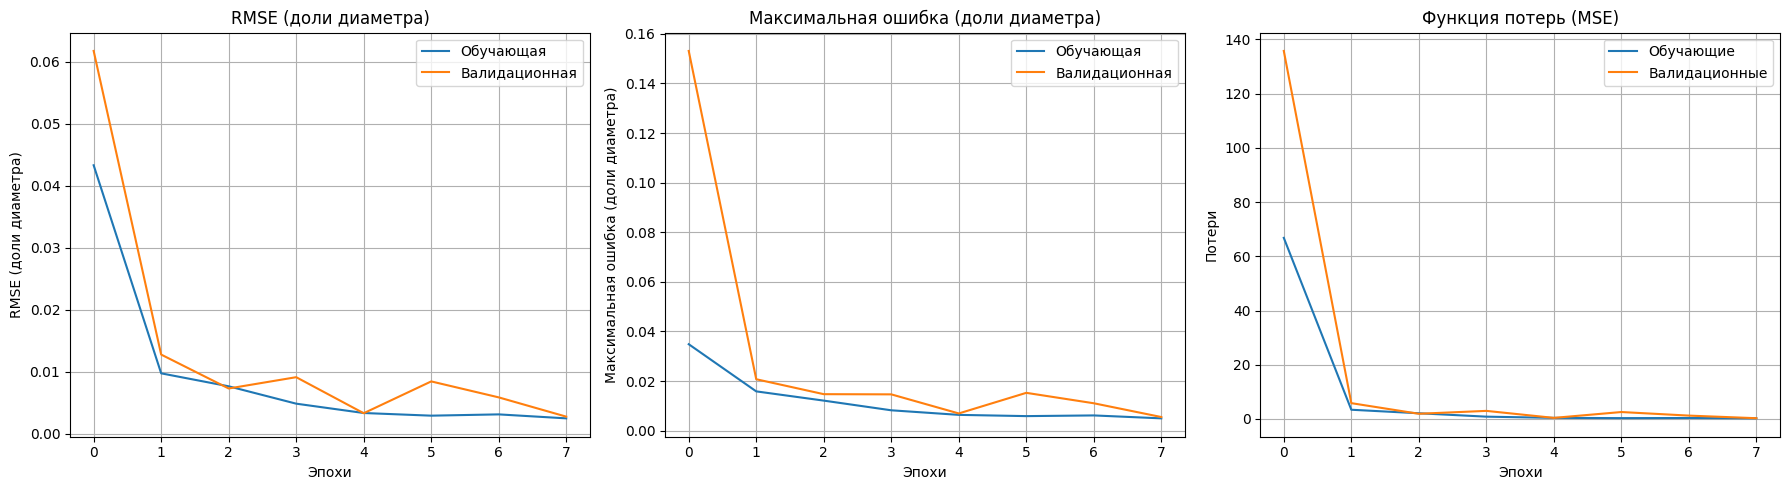

In [9]:
# Оценка на тестовом наборе с преобразованием в доли диаметра
test_loss, test_rmse_pixels, test_max_error_pixels = model.evaluate(test_ds, verbose=0)

# Преобразование ошибок в доли диаметра
test_rmse_diameter = pixels_to_diameter_fraction(test_rmse_pixels)
test_max_error_diameter = pixels_to_diameter_fraction(test_max_error_pixels)

print(f"\nДиаметр пятна: {d_pix:.2f} пикселей")
print(f"\nОшибки на тестовом наборе:")
print(f"RMSE: {test_rmse_pixels:.2f} пикселей ({test_rmse_diameter:.4f} долей диаметра)")
print(f"Максимальная ошибка: {test_max_error_pixels:.2f} пикселей ({test_max_error_diameter:.4f} долей диаметра)")

# Функция для преобразования истории обучения в доли диаметра
def convert_history_to_diameter_fraction(history):
    history_diameter = {}
    for key, values in history.history.items():
        if 'rmse' in key or 'max_error' in key:
            # Преобразуем метрики из пикселей в доли диаметра
            history_diameter[key] = [pixels_to_diameter_fraction(val) for val in values]
        else:
            history_diameter[key] = values
    return history_diameter

# Преобразуем историю обучения
history_diameter = convert_history_to_diameter_fraction(history)

# Визуализация обучения в долях диаметра
plt.figure(figsize=(18, 5))

# График RMSE в долях диаметра
plt.subplot(1, 3, 1)
plt.plot(history_diameter['rmse'], label='Обучающая')
plt.plot(history_diameter['val_rmse'], label='Валидационная')
plt.title('RMSE (доли диаметра)')
plt.xlabel('Эпохи')
plt.ylabel('RMSE (доли диаметра)')
plt.legend()
plt.grid(True)

# График максимальной ошибки в долях диаметра
plt.subplot(1, 3, 2)
plt.plot(history_diameter['max_error'], label='Обучающая')
plt.plot(history_diameter['val_max_error'], label='Валидационная')
plt.title('Максимальная ошибка (доли диаметра)')
plt.xlabel('Эпохи')
plt.ylabel('Максимальная ошибка (доли диаметра)')
plt.legend()
plt.grid(True)

# График потерь
plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], label='Обучающие')
plt.plot(history.history['val_loss'], label='Валидационные')
plt.title('Функция потерь (MSE)')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Влияния смещения на ФПМ

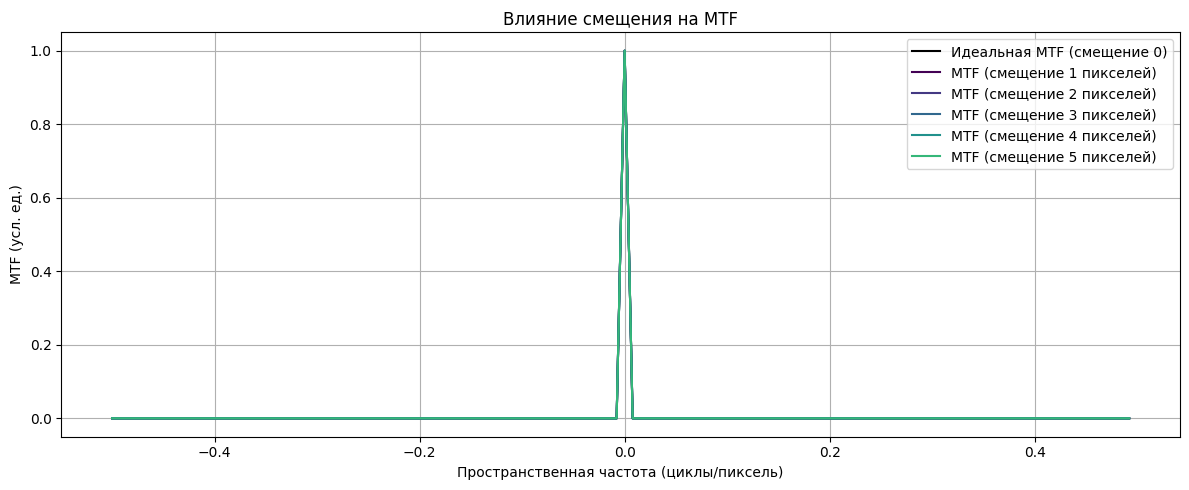

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift

# Параметры для генерации идеальной ФРТ
size = 128
x = np.linspace(-size/2, size/2-1, size)
y = np.linspace(-size/2, size/2-1, size)
X, Y = np.meshgrid(x, y)
r = np.sqrt(X**2 + Y**2)
lambda_ = 0.5  # Длина волны
d = 1.0  # Диаметр апертуры
k = 4.0
f_prime = 2000.0  # Заднее фокусное расстояние
f_prime_0 = 50.0  # Базовое фокусное расстояние
resolution = 0.1  # Разрешение, мкм/пиксель
airy_diameter = 2.44 * (f_prime / f_prime_0) * (lambda_ * k / d) / resolution  # Диаметр диска Эйри в пикселях
r_airy = airy_diameter / 2  # Радиус диска Эйри

# Идеальная PSF (диск Эйри)
ideal_psf = np.where(r <= r_airy, 1, 0)
ideal_psf = ideal_psf / np.sum(ideal_psf)  # Нормализация

# Вычисление идеальной MTF (модуль 2D Фурье-преобразования)
mtf_ideal = np.abs(fftshift(fft2(ideal_psf)))
mtf_ideal = mtf_ideal / mtf_ideal.max()  # Нормализация к 1

# Список для хранения MTF при разных смещениях
shifts = [0, 1, 2, 3, 4, 5]  # Сдвиги в пикселях (вправо)
mtf_curves = []

# Сдвиг PSF и вычисление MTF
for shift in shifts:
    # Сдвигаем PSF вправо (используем np.roll для циклического сдвига)
    shifted_psf = np.roll(ideal_psf, shift, axis=1)
    # Вычисляем MTF
    mtf_shifted = np.abs(fftshift(fft2(shifted_psf)))
    mtf_shifted = mtf_shifted / mtf_shifted.max()  # Нормализация
    mtf_curves.append(mtf_shifted)

# Извлечение центральной горизонтальной линии для 1D MTF (для упрощения визуализации)
freq = np.linspace(-size/2, size/2-1, size) / size  # Пространственная частота
mtf_ideal_1d = mtf_ideal[size//2, :]
mtf_curves_1d = [curve[size//2, :] for curve in mtf_curves]

# Визуализация
plt.figure(figsize=(12, 5))
plt.plot(freq, mtf_ideal_1d, label='Идеальная MTF (смещение 0)', color='black')
for i, (shift, mtf) in enumerate(zip(shifts[1:], mtf_curves_1d[1:])):
    plt.plot(freq, mtf, label=f'MTF (смещение {shift} пикселей)', color=plt.cm.viridis(i / len(shifts)))
plt.title('Влияние смещения на MTF')
plt.xlabel('Пространственная частота (циклы/пиксель)')
plt.ylabel('MTF (усл. ед.)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Предсказание на случайном изображении из датасета

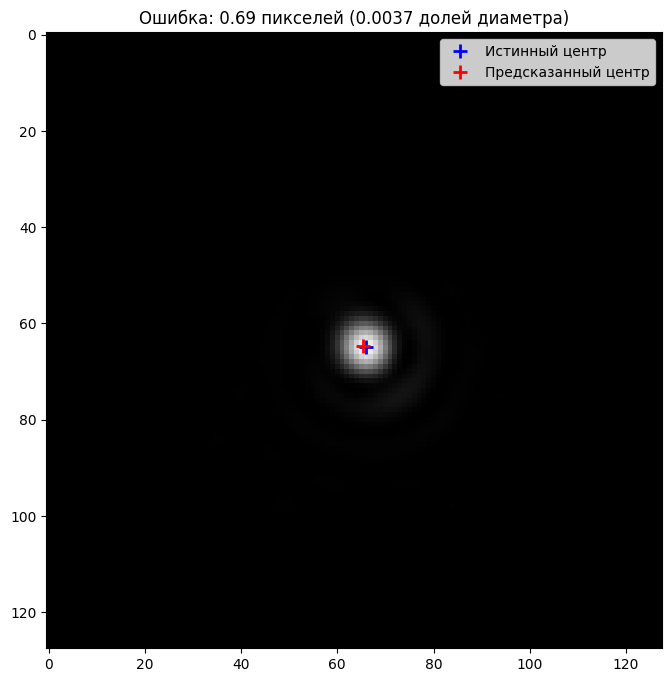

Истинный центр: (65.00, 66.00)
Предсказанный центр: (64.67, 65.39)
Ошибка в пикселях: 0.69
Ошибка в долях диаметра: 0.0037
Диаметр пятна: 188.64 пикселей


In [11]:
import random

# Тестовый датасет в виде списка
test_images = list(test_ds.unbatch().as_numpy_iterator())

# Выбираем случайное изображение
random_sample = random.choice(test_images)
sample_image = random_sample[0]
true_center = random_sample[1]

# # Обрезаем изображение вокруг центра, чтобы пятно было крупнее
# crop_size = 50  # Новый размер изображения 50x50
# center_x, center_y = int(true_center[1]), int(true_center[0])
# start_x = max(0, center_x - crop_size // 2)
# start_y = max(0, center_y - crop_size // 2)
# end_x = min(sample_image.shape[1], start_x + crop_size)
# end_y = min(sample_image.shape[0], start_y + crop_size)
# cropped_image = sample_image[start_y:end_y, start_x:end_x]
# 
# # Корректируем координаты центра для обрезанного изображения
# adjusted_true_center = [true_center[0] - start_y, true_center[1] - start_x]

display_image = sample_image
display_true_center = true_center

# Предсказание
sample_image_pred = sample_image[np.newaxis, ...]  # Добавляем batch-размерность
predicted_center = model.predict(sample_image_pred, verbose=0)[0]

# Корректируем предсказанные координаты для обрезанного изображения
# adjusted_pred_center = [predicted_center[0] - start_y, predicted_center[1] - start_x]

# Используем оригинальные предсказанные координаты
display_pred_center = predicted_center

# Расчет ошибки в пикселях и долях диаметра
error_pixels = np.linalg.norm(np.array(display_true_center) - np.array(display_pred_center))
error_diameter_fraction = pixels_to_diameter_fraction(error_pixels)

# Отображение результата
plt.figure(figsize=(8, 8))
plt.imshow(display_image.squeeze(), cmap='gray')
plt.plot(display_true_center[1], display_true_center[0], 'b+', markersize=10, markeredgewidth=2, label='Истинный центр')
plt.plot(display_pred_center[1], display_pred_center[0], 'r+', markersize=10, markeredgewidth=2, label='Предсказанный центр')
plt.title(f"Ошибка: {error_pixels:.2f} пикселей ({error_diameter_fraction:.4f} долей диаметра)")
plt.legend()
plt.show()

# Дополнительная информация
print(f"Истинный центр: ({display_true_center[0]:.2f}, {display_true_center[1]:.2f})")
print(f"Предсказанный центр: ({display_pred_center[0]:.2f}, {display_pred_center[1]:.2f})")
print(f"Ошибка в пикселях: {error_pixels:.2f}")
print(f"Ошибка в долях диаметра: {error_diameter_fraction:.4f}")
print(f"Диаметр пятна: {d_pix:.2f} пикселей")

# Сохранение модели

In [12]:
model.save('cnn_M_20x_k_4.h5')
print("Модель успешно сохранена")

Модель успешно сохранена
